In [2]:
import dynamiqs as dq
import jax.numpy as jnp
from jax.typing import ArrayLike
import matplotlib.pyplot as plt
import numpy as np
import jax

# Parameter definition

In [3]:
MHz = 2 * jnp.pi
kHz = 2 * jnp.pi * 1e-3
us = 1.0
ns = 1.0e-3

In [4]:
nbar_0 = 4.0
nbar_max = 20.0

Na, Nb = 42, 12
kappa_a = 1/(5*us)
kappa_b = 15*MHz
g2 = 2*MHz
kerr = 20*kHz
ed_max = -nbar_max*g2
t_max = 4*us
N_t = int(t_max//(4*ns))
times = jnp.linspace(0, t_max, N_t)
a, b = dq.destroy(Na, Nb)

2024-05-24 11:26:25.813479: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Simulation

In [5]:
def pride_pulse(x, period_ns: float, amp: float):
    y = abs((x[None, :] + period_ns[:, None]/4) % (period_ns[:, None])*4/period_ns[:, None] - 2) - 1
    return amp[:, None, None]*y[None, :, :-1]

In [6]:
@jax.jit
def simulate(period_ns: ArrayLike, amp: ArrayLike) -> tuple[float, float, float]: 
    H_kerr = kerr/2*dq.dag(a)@dq.dag(a)@a@a
    H_2 = g2*a@a@dq.dag(b) + g2*dq.dag(a@a@dq.dag(b))

    values_ed = pride_pulse(times, period_ns, amp)
    H_d = dq.pwc(times, values_ed, ed_max*b)
    H_d_d = dq.pwc(times, jnp.conj(values_ed), ed_max*dq.dag(b))

    H = H_kerr + H_2 + H_d + H_d_d

    L = [jnp.sqrt(kappa_a)*a, jnp.sqrt(kappa_b)*b]

    alpha = jnp.sqrt(nbar_0)
    cat_p = dq.unit(dq.coherent(Na, alpha) + dq.coherent(Na, -alpha))
    cat_m = dq.unit(dq.coherent(Na, alpha) - dq.coherent(Na, -alpha))

    rho_p = dq.tensor(cat_p, dq.fock(Nb, 0))
    output_p = dq.mesolve(H, L, rho_p, times, exp_ops=[b, a@dq.dag(a) - dq.dag(a)@a, b@dq.dag(b) - dq.dag(b)@b])

    rho_m = dq.tensor(cat_m, dq.fock(Nb, 0))
    output_m = dq.mesolve(H, L, rho_m, times, exp_ops=[b, a@dq.dag(a) - dq.dag(a)@a, b@dq.dag(b) - dq.dag(b)@b])

    dist = jnp.sqrt((jnp.abs(output_m.expects[:, :, 0] - output_p.expects[:, :, 0])**2).sum(axis=-1)*(times[1] - times[0]))
    
    error_a = jnp.max(jnp.concatenate([jnp.abs(output_p.expects[:, :, 1] - 1), jnp.abs(output_m.expects[:, :, 1] - 1)], axis=-1), axis=-1)
    error_b = jnp.max(jnp.concatenate([jnp.abs(output_p.expects[:, :, 2] - 1), jnp.abs(output_m.expects[:, :, 2] - 1)], axis=-1), axis=-1)
    
    return dist, error_a, error_b

# Results

In [22]:
simulate(jnp.array([150*ns]), jnp.array([1]))

100.00%|███████████████████████████████████████████████████████████████████| [00:12<00:00,  7.89%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:12<00:00,  7.78%/s]


(Array([[0.16581756]], dtype=float32),
 Array([[0.49299675]], dtype=float32),
 Array([[1.3399512]], dtype=float32))

In [ ]:
max_size = 1

periods_ns = jnp.linspace(0.1, 0.2, 21)*us
cutted_periods = np.array_split(periods_ns, np.ceil(len(periods_ns)/max_size))
length_cutted = [len(el) for el in cutted_periods]
indexes = np.concatenate(([0], np.cumsum(length_cutted)))
amps = jnp.linspace(0.5, 1, 21)

shape=(len(amps), len(periods_ns))
dists, error_a, error_b = np.zeros(shape), np.zeros(shape), np.zeros(shape)
for ind_amp, amp in enumerate(amps):
    for ind_per, periods in enumerate(cutted_periods):
        sub_dist, sub_error_a, sub_error_b = simulate(periods, jnp.array([amp]))
        dists[ind_amp, indexes[ind_per]: indexes[ind_per+1]] = sub_dist
        error_a[ind_amp, indexes[ind_per]: indexes[ind_per+1]] = sub_error_a
        error_b[ind_amp, indexes[ind_per]: indexes[ind_per+1]] = sub_error_b

100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.72%/s]
100.00%|█████████████████████████████████| [00:11<00:00,  8.72%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.67%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.71%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.65%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.72%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.65%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.70%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.62%/s]
100.00%|███████████████████████████████████████████████████████████████████| [00:11<00:00,  8.67%/s]
100.00%|████████████████

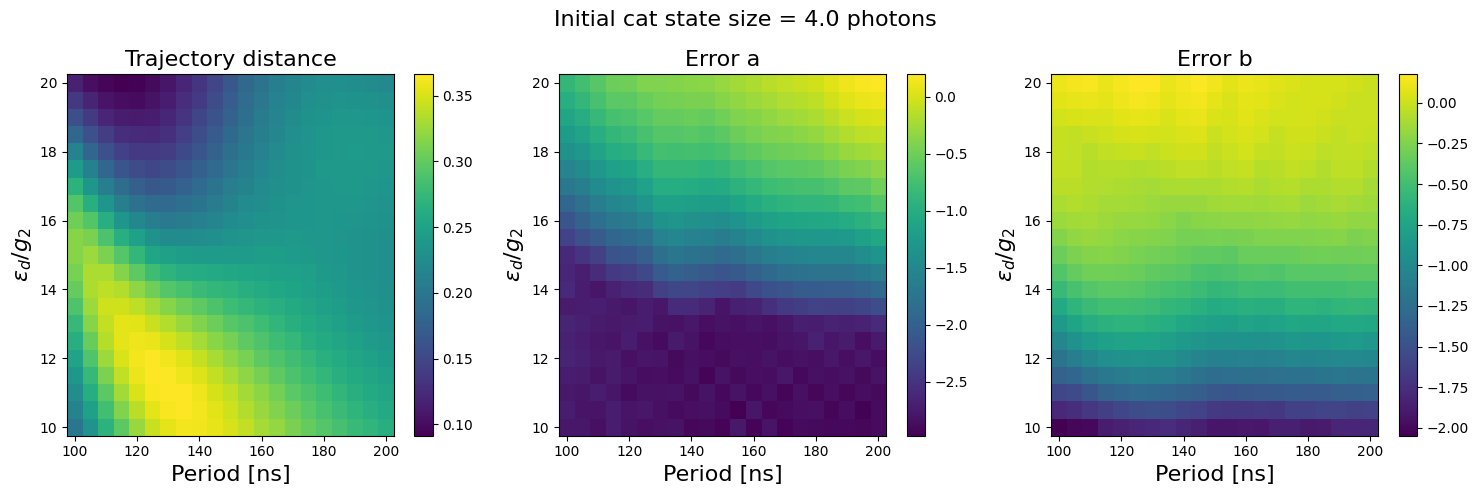

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
if len(amps) == 1:
    for ind, (data, title) in enumerate(zip([dists, np.log10(error_a), np.log10(error_b)], ['Distance', 'Error a', 'Error b'])):
        im = ax[ind].plot(periods_ns/us, data[0])
        ax[ind].set_xlabel('Period (us)')
        ax[ind].set_title(title)
        ax[ind].grid()
else:
    for ind, (data, title) in enumerate(zip([dists, np.log10(error_a), np.log10(error_b)], ['Trajectory distance', 'Error a', 'Error b'])):
        im = ax[ind].pcolormesh(periods_ns/ns, amps*nbar_max, data, shading='auto')
        fig.colorbar(im, ax=ax[ind])
        ax[ind].set_xlabel('Period [ns]', fontsize=16)
        ax[ind].set_ylabel('$\epsilon_d/g_2$', fontsize=16)
        ax[ind].set_title(title, fontsize=16)
fig.suptitle(f"Initial cat state size = {nbar_0} photons", fontsize=16)
fig.tight_layout()
plt.savefig(f'triangular_pride_fidelity_{int(np.round(periods_ns[0]/ns))}_{int(np.round(periods_ns[-1]/ns))}_ns_nbar_0_{int(nbar_0)}_nbar_max_{int(nbar_max)}.png')